# KAN (Ziming Liu) — Symbolic Branch ON, Target Function Only
开启符号分支 (symbolic_enabled=True)。在第 2 节粘贴你的目标函数即可。

In [1]:
# ============================================================
# KAN (Ziming Liu) + auto_symbolic (B1) + PySR 对比（完整脚本）
# ============================================================

# ---------- 0) Imports & device ----------
import os, sys, warnings, random 
warnings.filterwarnings("ignore")

# 线程数
T_TORCH = 28
T_JULIA = 28

# —— 在首次导入 PyTorch / juliacall 之前就设置好 ——
# Julia（PySR 用到）的线程
os.environ["PYTHON_JULIACALL_THREADS"]  = str(T_JULIA)
os.environ["JULIA_NUM_THREADS"]         = str(T_JULIA)
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"

# BLAS 线程锁 1，避免和 PyTorch/Julia 抢核（安全、常用）
os.environ["MKL_NUM_THREADS"]      = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
# 切记：不要设置 OMP_NUM_THREADS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import copy, inspect

import torch
torch.set_default_dtype(torch.float64)
torch.set_num_threads(T_TORCH)
torch.set_num_interop_threads(2)
device = torch.device("cpu")
print("Torch :", torch.__version__, "| CPU threads =", torch.get_num_threads())
from kan import KAN, create_dataset_from_data

np.random.seed(0); torch.manual_seed(0); random.seed(0)

Torch : 2.5.1 | CPU threads = 28


In [2]:
# ---------- 1) 你的目标函数（保持不变）----------
def target_signal(x):
    """
    f(x) = (4/pi)*sin(2*pi*10*x) + (4/pi)*(1/3)*sin(2*pi*30*x)
         + (2/pi)*sin(2*pi*(50*x + 20*x^2))
    x: (N,1) torch.Tensor
    """
    return ((4.0 / torch.pi) * torch.sin(2.0 * torch.pi * 10.0 * x[:, [0]])
          + (4.0 / torch.pi) * (1.0/3.0) * torch.sin(2.0 * torch.pi * 30.0 * x[:, [0]])
          + (2.0 / torch.pi) * torch.sin(2.0 * torch.pi * (50.0 * x[:, [0]] + 20.0 * x[:, [0]]**2)))

In [3]:
# ---------- 2) 采样与数据（-0.5 ~ 0.5） ----------
t_start, t_end = -0.5, 0.5     # 秒
fs = 15000                     # Hz
N = int((t_end - t_start) * fs)
x = torch.linspace(t_start, t_end, steps=N).unsqueeze(1)
y = target_signal(x)

dataset = create_dataset_from_data(x, y, train_ratio=0.8, device=device)

In [4]:
# ---------- 3) 画结构图的工具（官方 model.plot + 安全设置） ----------
FIG_DIR = "./fig_structure"; os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs("./model", exist_ok=True)   # 避免 history.txt 报错（pykan 会写 ./model）

def sanitize_model_(model, clamp=1e4):
    """把模型所有 NaN/Inf 参数替换为有限值，并做幅度截断。"""
    with torch.no_grad():
        for _, p in model.named_parameters():
            if not torch.isfinite(p).all():
                p.data = torch.nan_to_num(p.data, nan=0.0, posinf=clamp, neginf=-clamp)
            p.data.clamp_(-clamp, clamp)
    return model

def has_finite_output(m, ds, use_train=True):
    x_ = ds["train_input"] if use_train else ds["test_input"]
    with torch.no_grad():
        yhat = m(x_)
        return torch.isfinite(yhat).all()

def _safe_batch_size(ds, proposed):
    n_tr = ds["train_input"].shape[0]
    n_te = ds.get("test_input", ds["train_input"]).shape[0]
    return int(min(proposed, n_tr, n_te))

def plot_and_save(model, dataset, out_png, title=None, beta=50, scale=0.7):
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    # 自救：先保证输出有限
    if not has_finite_output(model, dataset):
        print("[plot] non-finite detected; warmup 40 @ 1e-4")
        model.fit(dataset, opt="Adam", steps=40, lr=1e-4,
                  batch=_safe_batch_size(dataset, 4096),
                  lamb=0.0, lamb_entropy=0.0)
    model.get_act(dataset["train_input"])
    # 两次尝试
    for (m, b) in [("forward_n", beta), ("forward_n", 40)]:
        try:
            model.plot(beta=b, metric=m, scale=scale, title=title)
            plt.savefig(out_png, bbox_inches="tight", dpi=300); plt.close()
            print(f"[Saved] {out_png} (metric={m}, beta={b})")
            return
        except Exception as e:
            print(f"[plot] retry due to: {e}")
            model.fit(dataset, opt="Adam", steps=30, lr=8e-5,
                      batch=_safe_batch_size(dataset, 2048),
                      lamb=0.0, lamb_entropy=0.0)
            model.get_act(dataset["train_input"])
    print(f"[plot] skip {out_png} (still non-finite)")

def stabilize_after_refine(model, dataset,
                           lr_seq=(5e-4, 2e-4, 1e-4, 5e-5, 2e-5),
                           adam_steps=80, lbfgs_steps=150, lbfgs_lr=0.05,
                           batch_warmup=4096):
    """逐步减小 lr 的小批量 Adam；必要时小步 LBFGS 兜底。"""
    for lr in lr_seq:
        sanitize_model_(model)
        bs = _safe_batch_size(dataset, batch_warmup)
        print(f"[Warmup] Adam {adam_steps} @ lr={lr}, batch={bs}")
        model.fit(dataset, opt="Adam", steps=adam_steps, lr=lr, batch=bs, lamb=0.0, lamb_entropy=0.0)
        if has_finite_output(model, dataset):
            return model
        print("[Warmup] still non-finite; try smaller lr...")
    sanitize_model_(model)
    print(f"[Warmup] fallback LBFGS {lbfgs_steps} @ lr={lbfgs_lr}")
    model.fit(dataset, opt="LBFGS", steps=lbfgs_steps, lr=lbfgs_lr, batch=-1, lamb=0.0, lamb_entropy=0.0)
    return model


In [5]:
# ---------- 4) 构建模型（输出前一层 3 个结点） ----------
width        = [1, 12, 3, 1]   # 你指定：前一层固定 3 个结点
grid0        = 40
refine_grids = [60, 90]        # 逐级 refine

steps_adam   = 300
steps_lbfgs  = 300
lrs_adam     = [1e-2, 5e-3, 5e-3]       # g=40 / 60 / 90
lrs_lbfgs    = [0.3,   0.2,   0.15]     # g=40 / 60 / 90

model = KAN(
    width=width,
    grid=grid0,
    k=3,
    seed=0,
    device=device,
    save_act=True,
    symbolic_enabled=True,   # 符号分支开启
    auto_save=True,
    ckpt_path="./model",
)

checkpoint directory created: ./model
saving model version 0.0


In [6]:
# ===== 阶段 0：初始化结构 =====
plot_and_save(model, dataset, f"{FIG_DIR}/00_init.png", title="KAN init")

# ===== 阶段 1：grid=40，Adam→LBFGS =====
print("[Stage 1/A] Adam warm-up @ grid=40 ...")
model.fit(dataset, opt="Adam",  steps=steps_adam,  lr=lrs_adam[0],  batch=-1, lamb=0.0, lamb_entropy=0.0)
plot_and_save(model, dataset, f"{FIG_DIR}/10_after_adam_g40.png", title="After Adam (g=40)")

print("[Stage 1/B] LBFGS polish @ grid=40 ...")
model.fit(dataset, opt="LBFGS", steps=steps_lbfgs, lr=lrs_lbfgs[0], batch=-1, lamb=0.0, lamb_entropy=0.0)
plot_and_save(model, dataset, f"{FIG_DIR}/20_after_lbfgs_g40.png", title="After LBFGS (g=40)")

# ===== 阶段 2：refine -> 60，先小步稳定，再画，再 Adam+LBFGS =====
print("[Refine] -> grid=60")
model = model.refine(new_grid=refine_grids[0])
model = stabilize_after_refine(model, dataset,
                               lr_seq=(5e-4, 2e-4, 1e-4, 5e-5),
                               adam_steps=80, lbfgs_steps=120, lbfgs_lr=0.06,
                               batch_warmup=4096)

# ===== 阶段 3：refine -> 90，先小步稳定，再画，再 Adam+LBFGS =====
print("[Refine] -> grid=90")
model = model.refine(new_grid=refine_grids[1])
model = stabilize_after_refine(model, dataset,
                               lr_seq=(4e-4, 2e-4, 1e-4, 5e-5, 2e-5),
                               adam_steps=80, lbfgs_steps=150, lbfgs_lr=0.05,
                               batch_warmup=4096)


[Saved] ./fig_structure/00_init.png (metric=forward_n, beta=50)
[Stage 1/A] Adam warm-up @ grid=40 ...


| train_loss: 1.23e-01 | test_loss: 1.27e-01 | reg: 1.25e+01 | : 100%|█| 300/300 [01:41<00:00,  2.95


saving model version 0.1
[Saved] ./fig_structure/10_after_adam_g40.png (metric=forward_n, beta=50)
[Stage 1/B] LBFGS polish @ grid=40 ...


| train_loss: 1.25e-03 | test_loss: 1.65e-03 | reg: 1.26e+01 | : 100%|█| 300/300 [28:28<00:00,  5.69


saving model version 0.2
[Saved] ./fig_structure/20_after_lbfgs_g40.png (metric=forward_n, beta=50)
[Refine] -> grid=60
saving model version 0.3
[Warmup] Adam 80 @ lr=0.0005, batch=3000


| train_loss: 1.02e-02 | test_loss: 9.62e-03 | reg: 1.25e+01 | : 100%|█| 80/80 [00:13<00:00,  5.72it


saving model version 0.4
[Refine] -> grid=90
saving model version 0.5
[Warmup] Adam 80 @ lr=0.0004, batch=3000


| train_loss: 3.48e-03 | test_loss: 3.82e-03 | reg: 1.25e+01 | : 100%|█| 80/80 [00:25<00:00,  3.17it


saving model version 0.6


In [7]:
# ---------- 5) 进一步精抛光（更细网格，保持 train/test 分离） ----------
print("\n=== [Block 5] refine & polish start ===")

def safe_refine_and_polish(model, dataset, g,
                           lr_adam=2e-3, lr_lbfgs=0.12,
                           steps_adam=80, steps_lbfgs=600,
                           max_retries=3):
    print(f"[safe_refine_and_polish] ENTER g={g}")

    # refine 本身如果报错，会在这里抛出来
    model = model.refine(new_grid=g)
    print(f"[safe_refine_and_polish] refined to grid={g}")
    sanitize_model_(model)
    sd_refined = copy.deepcopy(model.state_dict())  # 备份 refine 后的新网格初态

    for attempt in range(1, max_retries + 1):
        try:
            bs = _safe_batch_size(dataset, 4096)
            print(f"[g={g}] Try {attempt}/{max_retries} | Adam {steps_adam} @ lr={lr_adam}, batch={bs}")
            model.fit(dataset, opt="Adam",
                      steps=steps_adam, lr=lr_adam,
                      batch=bs, lamb=0.0, lamb_entropy=0.0)

            if not has_finite_output(model, dataset):
                raise RuntimeError("non-finite after Adam")

            print(f"[g={g}] Try {attempt}/{max_retries} | LBFGS {steps_lbfgs} @ lr={lr_lbfgs}")
            model.fit(dataset, opt="LBFGS",
                      steps=steps_lbfgs, lr=lr_lbfgs,
                      batch=-1, lamb=0.0, lamb_entropy=0.0)

            if not has_finite_output(model, dataset):
                raise RuntimeError("non-finite after LBFGS")

            out_png = f"{FIG_DIR}/polish_after_g{g}.png"
            print(f"[g={g}] plotting to {out_png} ...")
            plot_and_save(model, dataset, out_png, title=f"Polish after g={g}")

            print(f"[safe_refine_and_polish] SUCCESS g={g}")
            return model

        except Exception as e:
            print(f"[WARN] g={g} attempt {attempt} failed: {e}")
            print("[WARN] rollback to refined init & reduce lr")
            model.load_state_dict(sd_refined)  # 回到 refine 后的新网格初态
            sanitize_model_(model)
            lr_adam  *= 0.5
            lr_lbfgs *= 0.5
            steps_adam = int(steps_adam * 1.25)

    print(f"[safe_refine_and_polish] SKIP g={g} (still unstable after {max_retries} tries)")
    return model


# —— 建议只做到 120；150 视稳定性尝试 ——
print("[Block 5] calling safe_refine_and_polish for g=120 ...")
model = safe_refine_and_polish(
    model, dataset,
    g=120,
    lr_adam=2e-3,  lr_lbfgs=0.12,
    steps_adam=80, steps_lbfgs=600
)
print("[Block 5] done g=120")

print("[Block 5] calling safe_refine_and_polish for g=150 ...")
model = safe_refine_and_polish(
    model, dataset,
    g=150,
    lr_adam=1.5e-3, lr_lbfgs=0.08,
    steps_adam=80,  steps_lbfgs=600
)
print("[Block 5] done g=150")

print("=== [Block 5] refine & polish finished ===")


# # —— 全数据抛光（稳定 & 保留原 test 评估，避免 nan）——
# dataset_full = create_dataset_from_data(x, y, train_ratio=1.0, device=device)
# # 关键：把原来的 test 集“接回去”，让 fit() 能正常计算 test_loss
# dataset_full["test_input"] = dataset["test_input"]
# dataset_full["test_label"] = dataset["test_label"]

# print("[Final polish on full dataset] LBFGS @ lr=0.06")
# model.fit(
#     dataset_full,
#     opt="LBFGS",
#     steps=400,
#     lr=0.06,
#     batch=-1,
#     lamb=0.0,
#     lamb_entropy=0.0,
# )

# plot_and_save(
#     model, dataset_full,
#     f"{FIG_DIR}/final_fullset_polish.png",
#     title="Final polish (full set)"
# )

# # （可选）极小步的最终抛光，进一步压误差
# model.fit(dataset_full, opt="LBFGS", steps=120, lr=0.03, batch=-1, lamb=0.0, lamb_entropy=0.0)



=== [Block 5] refine & polish start ===
[Block 5] calling safe_refine_and_polish for g=120 ...
[safe_refine_and_polish] ENTER g=120
saving model version 0.7
[safe_refine_and_polish] refined to grid=120
[g=120] Try 1/3 | Adam 80 @ lr=0.002, batch=3000


| train_loss: 9.38e-03 | test_loss: 1.06e-02 | reg: 1.23e+01 | : 100%|█| 80/80 [00:26<00:00,  3.06it


saving model version 0.8
[g=120] Try 1/3 | LBFGS 600 @ lr=0.12


| train_loss: 1.34e-04 | test_loss: 5.44e-04 | reg: 1.24e+01 | : 100%|█| 600/600 [3:16:58<00:00, 19.


saving model version 0.9
[g=120] plotting to ./fig_structure/polish_after_g120.png ...
[Saved] ./fig_structure/polish_after_g120.png (metric=forward_n, beta=50)
[safe_refine_and_polish] SUCCESS g=120
[Block 5] done g=120
[Block 5] calling safe_refine_and_polish for g=150 ...
[safe_refine_and_polish] ENTER g=150
saving model version 0.10
[safe_refine_and_polish] refined to grid=150
[g=150] Try 1/3 | Adam 80 @ lr=0.0015, batch=3000


| train_loss: 6.27e-03 | test_loss: 6.58e-03 | reg: 1.23e+01 | : 100%|█| 80/80 [00:33<00:00,  2.36it


saving model version 0.11
[g=150] Try 1/3 | LBFGS 600 @ lr=0.08


| train_loss: 5.07e-05 | test_loss: 3.46e-04 | reg: 1.23e+01 | : 100%|█| 600/600 [5:27:42<00:00, 32.


saving model version 0.12
[g=150] plotting to ./fig_structure/polish_after_g150.png ...
[Saved] ./fig_structure/polish_after_g150.png (metric=forward_n, beta=50)
[safe_refine_and_polish] SUCCESS g=150
[Block 5] done g=150
=== [Block 5] refine & polish finished ===


In [8]:
# ============================================================
# KAN(数值, 原模型) vs PySR(符号, 直接对数据) vs PySR(符号蒸馏自KAN)
# ============================================================
# ---------- 0) 构造 PySR 的增强特征：[x, x^2] ----------
Xtr = dataset["train_input"].cpu().numpy()
Xts = dataset["test_input"].cpu().numpy()
Xtr_feat = np.hstack([Xtr, Xtr**2])   # [x, x^2]
Xts_feat = np.hstack([Xts, Xts**2])
ytr = dataset["train_label"].cpu().numpy().ravel()
yts = dataset["test_label"].cpu().numpy().ravel()

# ---------- A) KAN 数值（已有） ----------
with torch.no_grad():
    yts_kan = model(dataset["test_input"]).cpu().numpy().ravel()
mse_kan = mean_squared_error(yts, yts_kan)
r2_kan  = r2_score(yts, yts_kan)
print(f"[KAN-num] MSE: {mse_kan:.6e}   R2: {r2_kan:.6f}")

# ---------- B) KAN auto_symbolic（在模型“副本”上，不污染数值最优模型） ----------
kan_sym_mse = np.nan
kan_sym_r2  = np.nan
kan_sym_expr = "(formula unavailable)"
try:
    model_sym = copy.deepcopy(model)

    # 建议先做一次“消毒”，避免 refine/插值后可能残留的非有限值（如果你前面定义了这个函数）
    if "sanitize_model_" in globals():
        sanitize_model_(model_sym)

    # 选择尽量精简但能表达相位的库；chirp 难点在 sin 内部的 x + x^2
    lib = ['sin', 'x', 'x^2']  # 可加 'tanh','exp' 等，但先保持简洁
    print("[KAN-symbolic] auto_symbolic on a copy ...")
    model_sym.auto_symbolic(lib=lib)

    # 小步 LBFGS 让替换后的符号参数贴合；步数和 lr 不要太大，防止又“数值化”
    model_sym.fit(dataset, opt="LBFGS", steps=80, lr=0.05, batch=-1, lamb=0.0, lamb_entropy=0.0)

    # 评估
    with torch.no_grad():
        yts_kansym = model_sym(dataset["test_input"]).cpu().numpy().ravel()
    kan_sym_mse = mean_squared_error(yts, yts_kansym)
    kan_sym_r2  = r2_score(yts, yts_kansym)

    # 符号式（不同版本返回结构略有差异，这里做个稳健处理）
    try:
        sym = model_sym.symbolic_formula()
        if isinstance(sym, (list, tuple)):
            if len(sym) > 0 and isinstance(sym[0], (list, tuple)) and len(sym[0]) > 0:
                kan_sym_expr = str(sym[0][0])
            else:
                kan_sym_expr = str(sym)
        else:
            kan_sym_expr = str(sym)
    except Exception:
        pass

    print(f"[KAN-symbolic(copy)] MSE: {kan_sym_mse:.6e}   R2: {kan_sym_r2:.6f}")
    print("[KAN-symbolic(copy)] formula:", kan_sym_expr)

except Exception as e:
    print("[KAN-symbolic(copy)] failed:", e)
    kan_sym_mse = np.nan
    kan_sym_r2  = np.nan
    kan_sym_expr = "(auto_symbolic failed)"


[KAN-num] MSE: 1.198173e-07   R2: 1.000000
[KAN-symbolic] auto_symbolic on a copy ...
fixing (0,0,0) with x, r2=0.5206679950859754, c=1
fixing (0,0,1) with x, r2=0.9585570687014919, c=1
fixing (0,0,2) with x, r2=0.8407136672970337, c=1
fixing (0,0,3) with x, r2=0.41443943989669224, c=1
fixing (0,0,4) with x, r2=0.8830695256577931, c=1
fixing (0,0,5) with x, r2=0.8932221922927561, c=1
fixing (0,0,6) with x, r2=0.6710856110219665, c=1
fixing (0,0,7) with x, r2=0.95921558094206, c=1
fixing (0,0,8) with x, r2=0.7205224686728667, c=1
fixing (0,0,9) with x, r2=0.9271554803282149, c=1
fixing (0,0,10) with x, r2=0.9231988487022258, c=1
fixing (0,0,11) with x, r2=0.8714951683938763, c=1
fixing (1,0,0) with x, r2=0.29793935858701975, c=1
fixing (1,0,1) with x, r2=0.48906272399417494, c=1
fixing (1,0,2) with x, r2=0.028902185136414797, c=1
fixing (1,1,0) with x, r2=0.08072290346577239, c=1
fixing (1,1,1) with x, r2=0.531605767690003, c=1
fixing (1,1,2) with x, r2=0.30352474174471483, c=1
fixing (

| train_loss: 1.06e+00 | test_loss: 1.05e+00 | reg: 0.00e+00 | : 100%|█| 80/80 [09:42<00:00,  7.28s/


saving model version 0.14
[KAN-symbolic(copy)] MSE: 1.094947e+00   R2: 0.007942
[KAN-symbolic(copy)] formula: -0.291822784298548*x_1 - 0.000309395165041471


In [9]:
# ---------- 2) 自适配版 PySR 初始化（兼容不同版本关键字） ----------
# ----- 进入 PySR：先设置 Julia 线程，再 import juliacall / pysr -----
# ---------- 进入 PySR 阶段（设置并行，避免线程套线程） ----------
from juliacall import Main as jl
jl.seval("using LinearAlgebra; BLAS.set_num_threads(1)")
print("Julia threads =", jl.seval("Threads.nthreads()"),
      "| Julia BLAS threads =", jl.seval("LinearAlgebra.BLAS.get_num_threads()"))

from pysr import PySRRegressor

def pysr_init_robust(niter=800, pop=1200, use_div_pow=False, seed=0):
    sig = inspect.signature(PySRRegressor.__init__).parameters
    kwargs = dict(
        niterations=niter,
        population_size=pop,
        binary_operators=["+", "-", "*"] + (["/","^"] if use_div_pow else []),
        unary_operators=["sin"],
        maxsize=35,
        model_selection="best",
        random_state=seed,
        progress=True,   # ✅ 打开进度条
    )

    # 单机优先多线程
    if "parallelism" in sig:
        kwargs["parallelism"] = "multithreading"
    if "procs" in sig:
        kwargs["procs"] = 0

    if "batching" in sig:   kwargs["batching"] = True
    if "batch_size" in sig: kwargs["batch_size"] = 4096
    if "precision" in sig:  kwargs["precision"] = 64

    if "variable_names" in sig:
        kwargs["variable_names"] = ["x", "x2"]
    elif "feature_names" in sig:
        kwargs["feature_names"] = ["x", "x2"]

    if "nested_constraints" in sig:
        kwargs["nested_constraints"] = {"sin": {"sin": 0}}

    # 新版 PySR 里有 verbosity 的话，顺便开一档
    if "verbosity" in sig:
        kwargs["verbosity"] = 1

    return PySRRegressor(**kwargs)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Julia threads = 28 | Julia BLAS threads = 1


In [10]:
# ---------- 3) PySR：直接对原数据做符号回归 ----------
sr_data = pysr_init_robust(niter=40, pop=200, use_div_pow=False, seed=0)
print("[PySR-data] start fitting...")
sr_data.fit(Xtr_feat, ytr)
print("[PySR-data] finished.")

# 提取表达式 & 在 test 上评估
expr_data = sr_data.sympy()
print("[PySR-data] best expression:", expr_data)

yts_sr_data = sr_data.predict(Xts_feat)
mse_sr_data = mean_squared_error(yts, yts_sr_data)
r2_sr_data  = r2_score(yts, yts_sr_data)
print(f"[PySR-data] test MSE={mse_sr_data:.6e}, R²={r2_sr_data:.6f}")

Compiling Julia backend...


[PySR-data] start fitting...


[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 0 / 1240 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Progress: 0 / 1240 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.122e+00  0.000e+00  y = -0.00069494
3           1.115e+00  3.165e-03  y = x₀ * -0.29193
4           3.450e-01  1.173e+00  y = sin(x₀ * 62.731)
6           3.070e-01  5.838e-02  y = sin(x₀ * 62.74) * 1.2741
8           3.060e-01  1.527e-03  y = sin((x₁ - 62.893) * x₀) * -1.2787
10          3.057e-01  5.943e-04  y = sin((63.045 - (x₁ + x₁)) * x₀) * 1.2716
13          2.004e-01  1.407e-01  y = sin(x₀ * 62.745) * (sin((x₀ * 125.38) + 1.5917) + 1.77...
                                      16)
15          2.001e-01  7.283e-04  y = sin((x₀ * 62.748) + 0.01191) * (sin((x₀ * 125.39) + 1....
                                      6108) + 1.7726)
19          1.996e-01  7.171e-04  y = (sin(x₀ * 62.771) + (sin(x₁ - ((x₀ - (x₀ * -1.973)) * ...
                                      -63.314)) * 0.37115)) * 1.2759
21          1.968e-01  6.973e-03  

In [11]:
# ---------- 4) PySR：蒸馏自 KAN（teacher→student），提升符号质量 ----------
# 用 KAN 的输出作训练目标（而非原 y），让搜索更容易到“正确结构”
with torch.no_grad():
    ytr_kan = model(dataset["train_input"]).cpu().numpy().ravel()

sr_distill = pysr_init_robust(niter=40, pop=200, use_div_pow=False, seed=1)
print("[PySR-distill] start fitting...")
sr_distill.fit(Xtr_feat, ytr_kan)
print("[PySR-distill] finished.")

expr_distill = sr_distill.sympy()
print("[PySR-distill] best expression:", expr_distill)

yts_sr_distill = sr_distill.predict(Xts_feat)
mse_sr_distill = mean_squared_error(yts, yts_sr_distill)
r2_sr_distill  = r2_score(yts, yts_sr_distill)
print(f"[PySR-distill] test MSE={mse_sr_distill:.6e}, R²={r2_sr_distill:.6f}")

[PySR-distill] start fitting...


[ Info: Started!



Expressions evaluated per second: 0.000e+00
Progress: 0 / 1240 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Progress: 0 / 1240 total iterations (0.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
───────────────────────────────────────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


[PySR-distill] finished.
[PySR-distill] best expression: (sin(x0*(-62.562170708486356))*sin(x0*62.822008040197716) - 1*(-2.024808436664395))*sin(x0*62.754765331651974)
[PySR-distill] test MSE=2.234761e-01, R²=0.797523
  - outputs\20251107_234154_uHhxfI\hall_of_fame.csv


In [12]:
# ---------- 5) 汇总对比 ----------
summary = pd.DataFrame(
    [
        ["KAN (numeric)",               mse_kan,        r2_kan,        ""                  ],
        ["KAN (symbolic on copy)",      kan_sym_mse,    kan_sym_r2,    kan_sym_expr        ],
        ["PySR (direct on data)",       mse_sr_data,    r2_sr_data,    str(expr_data)      ],
        ["PySR (distilled from KAN)",   mse_sr_distill, r2_sr_distill, str(expr_distill)   ],
    ],
    columns=["Method", "MSE (test)", "R² (test)", "Expression"]
)
print("\n=== KAN vs PySR (same test split) ===")
print(summary.to_string(index=False))


=== KAN vs PySR (same test split) ===
                   Method   MSE (test)  R² (test)                                                                                                     Expression
            KAN (numeric) 1.198173e-07   1.000000                                                                                                               
   KAN (symbolic on copy) 1.094947e+00   0.007942                                                                  -0.291822784298548*x_1 - 0.000309395165041471
    PySR (direct on data) 2.022955e-01   0.816714               (sin(x0*125.37615953934936 + 1.5916961221683068) + 1.7716486406122223)*sin(x0*62.74523654153168)
PySR (distilled from KAN) 2.234761e-01   0.797523 (sin(x0*(-62.562170708486356))*sin(x0*62.822008040197716) - 1*(-2.024808436664395))*sin(x0*62.754765331651974)


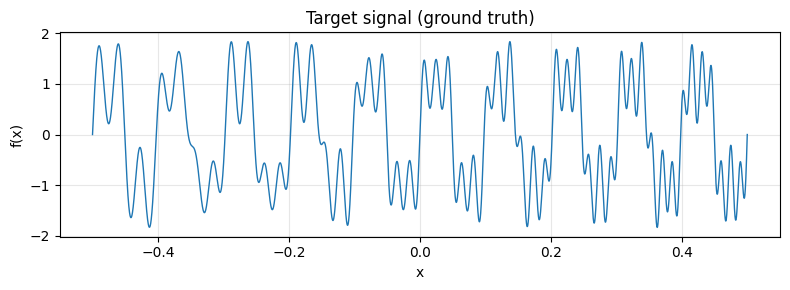

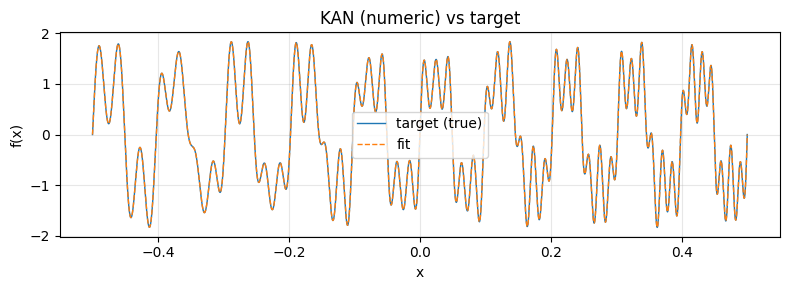

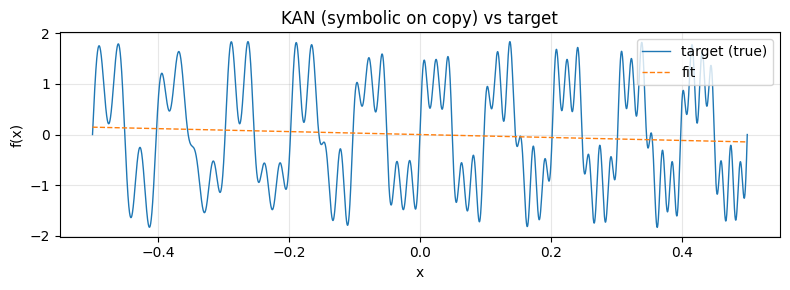

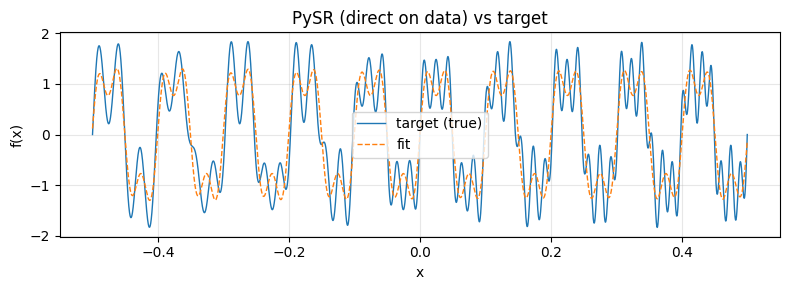

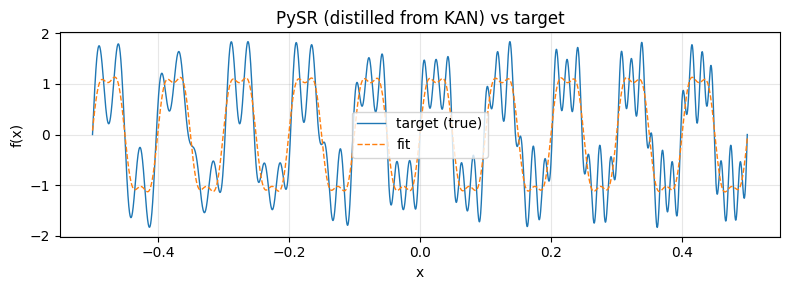

In [13]:
# ============================================================
# 6) 可视化对比：原函数 vs 四个拟合结果（共 5 张图）
# ============================================================
# 使用全区间 [-0.5, 0.5] 上的 x 画图
x_vis = x.cpu().numpy().ravel()
y_true = y.cpu().numpy().ravel()

def plot_fit(xv, y_true, y_pred, title):
    """在同一张图上画 原函数 vs 拟合结果"""
    plt.figure(figsize=(8, 3))
    plt.plot(xv, y_true, label="target (true)", linewidth=1)
    plt.plot(xv, y_pred, label="fit", linewidth=1, linestyle="--")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) 只画原函数（方便肉眼先看一下信号形状）
plt.figure(figsize=(8, 3))
plt.plot(x_vis, y_true, linewidth=1)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Target signal (ground truth)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) KAN 数值模型在全区间上的输出
with torch.no_grad():
    y_kan_full = model(x.to(device)).cpu().numpy().ravel()
plot_fit(x_vis, y_true, y_kan_full, "KAN (numeric) vs target")

# 3) KAN auto_symbolic（如果成功的话）
y_kansym_full = None
if ("model_sym" in globals()) and np.isfinite(kan_sym_mse):
    try:
        with torch.no_grad():
            y_kansym_full = model_sym(x.to(device)).cpu().numpy().ravel()
    except Exception as e:
        print("[WARN] plotting KAN-symbolic failed:", e)

if y_kansym_full is not None:
    plot_fit(x_vis, y_true, y_kansym_full, "KAN (symbolic on copy) vs target")
else:
    print("[INFO] KAN symbolic model unavailable for plotting.")

# 4) PySR 直接拟合真数据：在全区间预测
X_vis_feat = np.hstack([x_vis.reshape(-1, 1), x_vis.reshape(-1, 1)**2])
y_sr_data_full = sr_data.predict(X_vis_feat)
plot_fit(x_vis, y_true, y_sr_data_full, "PySR (direct on data) vs target")

# 5) PySR 蒸馏自 KAN：在全区间预测
y_sr_distill_full = sr_distill.predict(X_vis_feat)
plot_fit(x_vis, y_true, y_sr_distill_full, "PySR (distilled from KAN) vs target")